In [65]:
import pandas as pd
import numpy as np
import lightgbm as lgb

from os import listdir
from tqdm import tqdm

from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler 
from sklearn.model_selection import StratifiedKFold, ParameterSampler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

intput_path = "../input/"
output_path = "../output/"

In [ ]:
# df = pd.read_csv(output_path+"nn_aug_92303_12_test.csv")
# np.save(output_path+"nn_aug_92303_12_test.npy",df.target)

In [52]:
npys = [f for f in sorted(listdir(output_path)) if f.endswith("_oof.npy") and f[0]!="!" and "nn" in f]
npys

['nn_0.9163_oof.npy', 'nn_aug_0.92303_12_oof.npy']

In [54]:
path = output_path+"predictions/train/"
csvs = [f for f in sorted(listdir(path)) if f.endswith(".csv")][-7:-1]
csvs

['9199_xgboost_unique_10x_upsample_0104062006.csv',
 '9202_separate_feature_models_threshold_0.84_10fold_04042353.csv',
 '9211_catboost_unique_with_10x_upsample_3103172847.csv',
 '9212_catboost_unique_10x_upsample_5_balancer_0204172825.csv',
 '9215_catboost_unique_10x_upsample_3_balancer_0204145755.csv',
 '9222_catboost_multiplied_counter_10_folds_0504034846.csv']

In [73]:
scaler = StandardScaler() #MinMaxScaler StandardScaler

dt = pd.DataFrame()

df = pd.read_csv(intput_path+'train.csv.zip')
df = df[["target"]]

cols = []
for file in tqdm(npys):
    train = np.load(output_path+file).reshape(-1, 1)
    col = file[:-4]
    cols.append(col)
    df[col] = scaler.fit_transform(train)
    df[col] = df[col].rank()/len(df)
    
    test = np.load(output_path+file.replace("_oof.npy","_test.npy")).reshape(-1, 1)
    dt[col] = [x[0] for x in scaler.transform(test)]
    dt[col] = dt[col].rank()/len(dt)
    
for file in tqdm(csvs):
    train = pd.read_csv(path+file)["target"].values.reshape(-1, 1)
    col = file[:-4]
    cols.append(col)
    df[col] = scaler.fit_transform(train)
    df[col] = df[col].rank()/len(df)
    
    test = pd.read_csv((path+file).replace("/train/","/test/"))["target"].values.reshape(-1, 1)
    dt[col] = [x[0] for x in scaler.transform(test)]
    dt[col] = dt[col].rank()/len(dt)
    
df["avg"] = df[cols].mean(axis=1)
dt["avg"] = dt[cols].mean(axis=1)

dt.tail()

100%|██████████| 6/6 [00:02<00:00,  2.35it/s]


,nn_0.9163_oof,nn_aug_0.92303_12_oof,9199_xgboost_unique_10x_upsample_0104062006,9202_separate_feature_models_threshold_0.84_10fold_04042353,9211_catboost_unique_with_10x_upsample_3103172847,9212_catboost_unique_10x_upsample_5_balancer_0204172825,9215_catboost_unique_10x_upsample_3_balancer_0204145755,9222_catboost_multiplied_counter_10_folds_0504034846,avg
199995,0.616195,0.716770,0.690135,0.660345,0.701005,0.668475,0.700525,0.763175,0.689578
199996,0.417985,0.381620,0.274565,0.230530,0.303695,0.236135,0.274450,0.359545,0.309816
199997,0.128315,0.033505,0.045355,0.066400,0.045305,0.057385,0.050690,0.045770,0.059091
199998,0.801670,0.616760,0.751965,0.750130,0.761250,0.751150,0.744315,0.749940,0.740897
199999,0.235155,0.556040,0.709600,0.737930,0.670620,0.634435,0.638570,0.560230,0.592822


In [74]:
df[cols].corr()

,nn_0.9163_oof,nn_aug_0.92303_12_oof,9199_xgboost_unique_10x_upsample_0104062006,9202_separate_feature_models_threshold_0.84_10fold_04042353,9211_catboost_unique_with_10x_upsample_3103172847,9212_catboost_unique_10x_upsample_5_balancer_0204172825,9215_catboost_unique_10x_upsample_3_balancer_0204145755,9222_catboost_multiplied_counter_10_folds_0504034846
nn_0.9163_oof,1.000000,0.931969,0.923001,0.910637,0.930344,0.931595,0.930972,0.939375
nn_aug_0.92303_12_oof,0.931969,1.000000,0.954640,0.952477,0.963757,0.963243,0.963965,0.956561
9199_xgboost_unique_10x_upsample_0104062006,0.923001,0.954640,1.000000,0.961893,0.989996,0.987275,0.986992,0.967840
9202_separate_feature_models_threshold_0.84_10fold_04042353,0.910637,0.952477,0.961893,1.000000,0.966833,0.969253,0.969835,0.957670
9211_catboost_unique_with_10x_upsample_3103172847,0.930344,0.963757,0.989996,0.966833,1.000000,0.991028,0.991632,0.972158
9212_catboost_unique_10x_upsample_5_balancer_0204172825,0.931595,0.963243,0.987275,0.969253,0.991028,1.000000,0.995922,0.974884
9215_catboost_unique_10x_upsample_3_balancer_0204145755,0.930972,0.963965,0.986992,0.969835,0.991632,0.995922,1.000000,0.976787
9222_catboost_multiplied_counter_10_folds_0504034846,0.939375,0.956561,0.967840,0.957670,0.972158,0.974884,0.976787,1.000000


## AVG

In [75]:
roc_auc_score(df.target, df.avg)
# 0.9238835527418467

0.9241042831770332

## LogReg

In [123]:
%%time

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

df["clf"] = 0
dt["clf"] = 0

i = -1
for train_index, valid_index in skf.split(df[cols], df.target):
    i+=1
    
    X_train = df.loc[train_index, cols]
    X_valid = df.loc[valid_index, cols]

    y_train = df.loc[train_index, "target"]
    y_valid = df.loc[valid_index, "target"]
    
    clf = LogisticRegression(C=1,
                             solver="newton-cg", 
                             penalty="l2", 
                             n_jobs=-1, 
                             max_iter=100).fit(X_train, y_train) 
    
    y_pred = clf.predict_proba(X_valid)[:,1] 
    df.loc[valid_index, "clf"] = y_pred
    print(i, "ROC AUC:", round(roc_auc_score(y_valid, y_pred), 4))
    
    dt["clf"] += clf.predict_proba(dt[cols])[:,1] / skf.n_splits
    
print("\nROC AUC:", round(roc_auc_score(df.target, df["clf"]), 5))

0 ROC AUC: 0.9237
1 ROC AUC: 0.9232
2 ROC AUC: 0.9299
3 ROC AUC: 0.9257
4 ROC AUC: 0.9225

ROC AUC: 0.92496
CPU times: user 3.72 s, sys: 12.8 s, total: 16.5 s
Wall time: 13.2 s


In [ ]:
# 0 ROC AUC: 0.9237
# 1 ROC AUC: 0.9232
# 2 ROC AUC: 0.9299
# 3 ROC AUC: 0.9257
# 4 ROC AUC: 0.9225

# ROC AUC: 0.925
# CPU times: user 3.74 s, sys: 13.5 s, total: 17.2 s
# Wall time: 14.8 s

## SVM

In [ ]:
# %%time

# skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# df["svc"] = 0
# dt["svc"] = 0

# i = -1
# for train_index, valid_index in skf.split(df[cols], df.target):
#     i+=1
    
#     X_train = df.loc[train_index, cols]
#     X_valid = df.loc[valid_index, cols]

#     y_train = df.loc[train_index, "target"]
#     y_valid = df.loc[valid_index, "target"]
    
#     svc = SVC(C=10, probability=True).fit(X_train, y_train)  
    
#     y_pred = svc.predict_proba(X_valid)[:,1] 
#     df.loc[valid_index, "svc"] = y_pred
#     print(i, "ROC AUC:", round(roc_auc_score(y_valid, y_pred), 4))
    
#     dt["svc"] += svc.predict_proba(dt[cols].values) / skf.n_splits
    
# print("\nROC AUC:", round(roc_auc_score(df.target, df["svc"]), 4))

## NN

In [91]:
%%time

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

df["nei"] = 0
dt["nei"] = 0

i = -1
for train_index, valid_index in skf.split(df[cols], df.target):
    i+=1
    
    X_train = df.loc[train_index, cols]
    X_valid = df.loc[valid_index, cols]

    y_train = df.loc[train_index, "target"]
    y_valid = df.loc[valid_index, "target"]
    
    nei = KNeighborsClassifier(n_neighbors=5000, p=1, n_jobs=-1).fit(X_train, y_train) 
    
    y_pred = nei.predict_proba(X_valid)[:,1] 
    df.loc[valid_index, "nei"] = y_pred
    print(i, "ROC AUC:", round(roc_auc_score(y_valid, y_pred), 4))
    
    dt["nei"] += nei.predict_proba(dt[cols])[:,1] / skf.n_splits
    
print("\nROC AUC:", round(roc_auc_score(df.target, df["nei"]), 4))

0 ROC AUC: 0.9232
1 ROC AUC: 0.9232
2 ROC AUC: 0.9293
3 ROC AUC: 0.9247
4 ROC AUC: 0.9216

ROC AUC: 0.9243
CPU times: user 7h 3min 54s, sys: 7min 15s, total: 7h 11min 9s
Wall time: 31min 9s


In [ ]:
# 0 ROC AUC: 0.9232
# 1 ROC AUC: 0.9232
# 2 ROC AUC: 0.9293
# 3 ROC AUC: 0.9247
# 4 ROC AUC: 0.9216

# ROC AUC: 0.9243
# CPU times: user 7h 3min 54s, sys: 7min 15s, total: 7h 11min 9s
# Wall time: 31min 9s

## LGBM HPO

In [98]:
rounds = 10000
early_stop_rounds = 500

param_grid = {'num_leaves': list(range(10, 30)),
              'max_bin': [511, 1023, 2047],
              'min_data_in_leaf': list(range(10, 100, 10)),
              'min_sum_hessian_in_leaf': list(range(0, 10)),
              'learning_rate': np.linspace(0.01, 0.03, 31),
              "bagging_freq": list(range(1, 5)),
              "bagging_fraction": np.linspace(0.5, 1.0, 51),
              'feature_fraction': np.linspace(0.08, 1.0, 11),
              'lambda_l1': np.linspace(0, 3, 61),
              'lambda_l2': np.linspace(0, 3, 61)}

param_static = {'boosting_type': 'gbrt',
                'objective': 'binary',
                'tree_learner': 'serial',
                'metric': 'auc',
                'bagging_seed': 42,
                'seed': 42,
                'max_depth': -1,
                'verbose': -1,
                'n_jobs': -1}

param_list = list(ParameterSampler(param_grid, n_iter=100))

rounded_list = [dict((k, round(v, 6)) for (k, v) in d.items())
                for d in param_list]

results = []
for i, params in enumerate(rounded_list):
    print(params)

    for key in param_static:
        params[key] = param_static[key]

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    oof = np.zeros(len(df))
    res = 0

    j = 0
    for train_index, valid_index in skf.split(df[cols], df.target):
        j += 1

        X_train = df.loc[train_index, cols]
        X_valid = df.loc[valid_index, cols]

        y_train = df.loc[train_index, "target"]
        y_valid = df.loc[valid_index, "target"]

        d_train = lgb.Dataset(X_train, y_train, feature_name=cols)
        d_valid = lgb.Dataset(X_valid, y_valid, feature_name=cols)

        model = lgb.train(params,
                          d_train,
                          num_boost_round=rounds,
                          valid_sets=[d_train, d_valid],
                          valid_names=['train', 'valid'],
                          early_stopping_rounds=early_stop_rounds,
                          verbose_eval=0)

        oof[valid_index] = model.predict(X_valid)
        auc = round(roc_auc_score(y_valid, oof[valid_index]), 4)
        print(i, j, "CV score: {:<8.4f}".format(auc))
    
    res = round(roc_auc_score(df.target, oof), 4)
    print("\noof CV score: {:<8.4f}".format(res))
    
    results.append((params, res))
    for key in param_static:
        del params[key]

    sorted_results = sorted(results, key=lambda x: x[1], reverse=True)
    print("best:", sorted_results[0])
    
# 0 ROC AUC: 0.9236
# 1 ROC AUC: 0.9234
# 2 ROC AUC: 0.9299
# 3 ROC AUC: 0.9252
# 4 ROC AUC: 0.9222

# ROC AUC: 0.9246

{'num_leaves': 11, 'min_sum_hessian_in_leaf': 2, 'min_data_in_leaf': 10, 'max_bin': 1023, 'learning_rate': 0.012667, 'lambda_l2': 1.2, 'lambda_l1': 2.3, 'feature_fraction': 0.632, 'bagging_freq': 2, 'bagging_fraction': 0.73}
0 1 CV score: 0.9238  
0 2 CV score: 0.9235  
0 3 CV score: 0.9298  
0 4 CV score: 0.9253  
0 5 CV score: 0.9222  

oof CV score: 0.9247  
best: ({'num_leaves': 11, 'min_sum_hessian_in_leaf': 2, 'min_data_in_leaf': 10, 'max_bin': 1023, 'learning_rate': 0.012667, 'lambda_l2': 1.2, 'lambda_l1': 2.3, 'feature_fraction': 0.632, 'bagging_freq': 2, 'bagging_fraction': 0.73}, 0.9247)
{'num_leaves': 11, 'min_sum_hessian_in_leaf': 3, 'min_data_in_leaf': 70, 'max_bin': 2047, 'learning_rate': 0.018, 'lambda_l2': 1.2, 'lambda_l1': 1.8, 'feature_fraction': 0.724, 'bagging_freq': 3, 'bagging_fraction': 0.55}


KeyboardInterrupt: 

## LGBM

In [100]:
%%time

rounds = 1000
early_stop_rounds = 100


params = {'num_leaves': 11, 
             'min_sum_hessian_in_leaf': 2, 
             'min_data_in_leaf': 10, 
             'max_bin': 1023, 
             'learning_rate': 0.012667, 
             'lambda_l2': 1.2, 
             'lambda_l1': 2.3, 
             'feature_fraction': 0.632, 
             'bagging_freq': 2, 
             'bagging_fraction': 0.73,
             'boosting_type': 'gbrt',
            'objective': 'binary',
            'tree_learner': 'serial',
            'metric': 'auc',
            'bagging_seed': 42,
            'seed': 42,
            'max_depth': -1,
            'verbose': -1,
            'n_jobs': -1}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

df["lgb"] = 0
dt["lgb"] = 0

i = -1
for train_index, valid_index in skf.split(df[cols], df.target):
    i+=1
    
    X_train = df.loc[train_index, cols]
    X_valid = df.loc[valid_index, cols]

    y_train = df.loc[train_index, "target"]
    y_valid = df.loc[valid_index, "target"]
    
    d_train = lgb.Dataset(X_train, y_train, feature_name=cols)
    d_valid = lgb.Dataset(X_valid, y_valid, feature_name=cols)    
    
    model = lgb.train(params,
                      d_train,
                      num_boost_round=rounds,
                      valid_sets=[d_train, d_valid],
                      valid_names=['train','valid'],
                      early_stopping_rounds=early_stop_rounds,
                      verbose_eval=0) 

    y_pred = model.predict(X_valid)
    df.loc[valid_index, "lgb"] = y_pred
    print(i, "ROC AUC:", round(roc_auc_score(y_valid, y_pred), 4))
    
    dt["lgb"] += model.predict(dt[cols]) / skf.n_splits
    
print("\nROC AUC:", round(roc_auc_score(df.target, df["lgb"]), 4))

0 ROC AUC: 0.9238
1 ROC AUC: 0.9235
2 ROC AUC: 0.9298
3 ROC AUC: 0.9253
4 ROC AUC: 0.9222

ROC AUC: 0.9247
CPU times: user 14min 21s, sys: 2.17 s, total: 14min 23s
Wall time: 31.8 s


In [ ]:
# 0 ROC AUC: 0.9236
# 1 ROC AUC: 0.9234
# 2 ROC AUC: 0.9299
# 3 ROC AUC: 0.9252
# 4 ROC AUC: 0.9222

# ROC AUC: 0.9246
# CPU times: user 7min 39s, sys: 1.63 s, total: 7min 40s
# Wall time: 17.2 s

Text(0.5,1,'Light GBM Feature Importance')

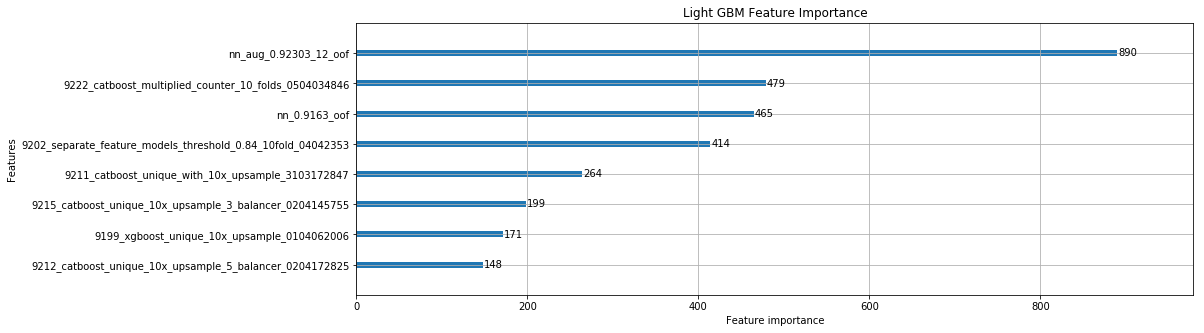

In [101]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(15, 5))
lgb.plot_importance(model, max_num_features=len(cols), ax=ax)
plt.title("Light GBM Feature Importance")

In [124]:
w = [1,1,100]

df["blend"] = (w[0]*df["lgb"]+w[1]*df["nei"]+w[2]*df["clf"])/sum(w)
dt["blend"] = (w[0]*dt["lgb"]+w[1]*dt["nei"]+w[2]*dt["clf"])/sum(w)

print("\nROC AUC:", round(roc_auc_score(df.target, df["blend"]), 5))


ROC AUC: 0.92496


In [125]:
sub = pd.read_csv(intput_path+'sample_submission.csv.zip')
sub["target"] = dt["blend"]
sub.head()

,ID_code,target
0,test_0,0.145423
1,test_1,0.351417
2,test_2,0.324999
3,test_3,0.163510
4,test_4,0.051385


In [126]:
sub.to_csv(output_path + "best_blend_8.csv", index=False)

In [127]:
!ls ../output/

 best_auc_nn.pkl	  cat_0.91617_test.npy	 nn_aug_0.92303_12_oof.npy
 best_blend_10.csv	  data_1_cont.pkl	 nn_aug_0.92303_12_test.npy
 best_blend_13.csv	  lgb_0.91145_oof.npy	 predictions
 best_blend_7.csv	  lgb_0.91145_test.npy	 train_1.bin
 best_blend_8.csv	  lgb_0.91305_oof.npy	 train_1.feather
 best_blend.csv		  lgb_0.91305_test.npy	 train_1.npy
'!cat_0.91558_oof.npy'	  models		 valid_1.bin
'!cat_0.91558_test.npy'   nn_0.9163_oof.npy	 xgb_0.91221_oof.npy
 cat_0.91617_oof.npy	  nn_0.9163_test.npy	 xgb_0.91221_test.npy


In [128]:
!kaggle competitions submit -c santander-customer-transaction-prediction -f ../output/best_blend_8.csv -m "0.92496 reg"

100%|███████████████████████████████████████| 6.17M/6.17M [00:06<00:00, 998kB/s]
Successfully submitted to Santander Customer Transaction Prediction